imports and pre processing

In [180]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

directory = os.getcwd()
data_path = os.path.join(directory, "data")

artists_file = os.path.join(data_path, "artists.dat")
artists_spotify_file = os.path.join(data_path, "data_by_artist_o.csv")
users_artists_file = os.path.join(data_path, "user_artists.dat")

#import data
artist_sp_df = pd.read_csv(artists_spotify_file)
print("artist_sp_df shape: ",artist_sp_df.shape)

artist_df = pd.read_csv(artists_file,sep="\t")
print("artist_df shape: ",artist_df.shape)

weights_df = pd.read_csv(users_artists_file,sep="\t")
print("weights_df shape: ",weights_df.shape)



artist_sp_df shape:  (28680, 16)
artist_df shape:  (17632, 4)
weights_df shape:  (92834, 3)


In [38]:
#remove weights outside of thresholds 
#Avoids issues with uncommon listening habits. 
#i.e: users that have played artist over 100k times
def remove_extreme_weights (df,min_weight,max_weight):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_weight = min # times a user must have played an aritst to keep the record
    max_weight = max # times a user must have played an aritst to keep the record
    '''    
    print('\n')
    print('**Remove Extreme (hig,low) Weights**')
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    bin_data = df.copy()
    labels = ['a.<10','b.10-1K','c.1K-5K','d.5K-10K','e.10K-20K','f.20K-50K','g.50K-100K','h.+100K']
    bins = [0, 10,1000,5000,10000,20000,50000,100000, np.inf]
    bin_data['weight_bin'] = pd.cut(bin_data['weight'], bins,labels=labels)
    print('original data binned:')
    print(bin_data['weight_bin'].value_counts(sort=False))
    print('\n')

    filtered_df = df[df['weight'].between(min_weight, max_weight)].reset_index(drop=True)
    print('df new shape: ',filtered_df.shape)
    sns.boxplot(y="weight", data=filtered_df)
    plt.title('Boxplot - Filtered Data')
    plt.show()
    print('filtered data - stats:')
    print(filtered_df['weight'].describe())
    print('\n')
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")
    
    return filtered_df

#source: https://github.com/statisticianinstilettos/recmetrics/blob/master/recmetrics/plots.py 

from matplotlib.lines import Line2D
def long_tail_plot(df, item_id_column, percentage=0.75):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)

    Returns:
    -------
        A long tail plot
    """
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()
    
    #line plot of cumulative volume
    ax=sns.lineplot(x = 'index', y="volume", data=volume_df.reset_index(), color="black")
    #set labels
    ax.set_title('Long Tail Plot of User weights by Artist')
    ax.set_ylabel('# of user weights')
    ax.set_xlabel(item_id_column)
    plt.tick_params(labelbottom = False)
    
    #plot vertical line at the tail location
    head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
    tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
    items_in_head = len(head)
    items_in_tail = len(tail)
    plt.axvline(x=items_in_head, color="red",  linestyle='--')

    # fill area under plot
    head = head.append(tail.head(1))
    x1 = head.index.values
    y1 = head['volume']
    x2 = tail.index.values
    y2 = tail['volume']
    ax.fill_between(x1, y1, color="blue", alpha=0.2)
    ax.fill_between(x2, y2,  color="orange", alpha=0.2)

    #create legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': artists in the head', markerfacecolor='blue', markersize=5),
                       Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': artists in the tail', markerfacecolor='orange', markersize=5)]
    ax.legend(handles=legend_elements, loc=1)

    plt.show()
    
    
def remove_popular_artists(df,artist_df,pct_remove):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    pct_remove: pct of top artists to remove. Example: 0.01 removes the top 1% artists with
    top count of users (popular)
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    print('\n')
    print('**Remove Highly Popular Artists**')
    #input dataset info
    print(f"input data shape: {df.shape}")
    print('unique artists: ',df['artistID'].nunique())

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)

    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of tot Users per Artist')
    #plt.ylabel('count of users')
    #plt.show()
    pct_plot = 0.8
    print(f"line divides top {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users): ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    threshold = artists_group['count'].quantile(1-pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] > threshold].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Distribution of tot Users per Artist - Filtered Dataset')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',pct_plot)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users) - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print('unique artists after removal: ',filtered_df['artistID'].nunique())
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df


def remove_rare_artists(df,artist_df,min_users):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    min_users: minimum number of users each artist must have 
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    print('\n')
    print('**Remove Rare Artists**')
    #input dataset info
    print(f"input data shape: {df.shape}")
    print('unique artists: ',df['artistID'].nunique())

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    pct_plot = 0.8
    print(f"line divides top {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    #threshold = artists_group['count'].quantile(pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] < min_users].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',0.8)
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print('unique artists after removal: ',filtered_df['artistID'].nunique())
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df


#remove users with low artist count. 
#Avoid issues if user only listens to 1 artist
def remove_users_lowcount (df,min_artists):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_artists = minimum number of artists a user must have listened to
    '''    
    print('\n')
    print('**Remove User with lowcount of samples (artists)**')
    print('df original shape: ',df.shape)
    print('unique users: ',df['userID'].nunique())

    grouped_df = df.groupby('userID', dropna=False).agg({'artistID':['count']})
    grouped_df = grouped_df.droplevel(axis=1, level=0)
    users_drop = grouped_df[grouped_df['count'] < min_artists].index

    print(f"users with less than {min_artists} artists: {len(users_drop)}")

    new_df = df[~df['userID'].isin(users_drop)].reset_index(drop=True)

    print('unique users after removal: ',new_df['userID'].nunique())
    print('df new shape: ',new_df.shape)
    print(f"% of removed records: {round(1-(new_df.shape[0]/df.shape[0]),4)}")
    return new_df

#scale weights at user level
#2 users might have a favorite artist, user 1 played such artist 100k times
#user 2 played such artist 10k times. However those users are still neighbors
#dont scale if your algorithm will already take care of this user-level bias

def scale_weight_by_user(df):
    '''
    Requires input dataframe with userID, artistID, weight columns
    Dont scale if your algorithm will already take care of this user-level bias
    '''  
    print('\n')
    print('**Scaling**')
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    scaled_df = df.copy()
    scaled_df['weight'] = scaled_df.groupby('userID')['weight'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    
    #adding 0.01 to provent 0 values
    scaled_df['weight'] = scaled_df['weight'] + 0.01
    #to handle 0 division
    scaled_df['weight'] = scaled_df['weight'].fillna(0.5)
    
    print('df scaled shape: ',scaled_df.shape)    
    sns.boxplot(y="weight", data=scaled_df)
    plt.title('Boxplot - Scaled Data')
    plt.show()
    
    return scaled_df

def train_test_split(df,sample_size,seed=1):
    '''
    Requires input dataframe with userID, artistID, weight columns
    sample_size = number of artists per user to sample for test set
    
    sample_size must be smaller than total artist count per user!!!
    
    '''  
    print('\n')
    print('**Train-Test Split**')
    print(f"input data shape: {df.shape}")
    
    np.random.seed(seed)
    sample = df.groupby('userID').apply(lambda x: x.sample(sample_size))
    sample_index = list(sample.index.get_level_values(1))
 
    train  = df[~df.index.isin(sample_index)]
    train.reset_index(drop=True,inplace=True)
    print(f"train set shape: {train.shape}")

    test  = df[df.index.isin(sample_index)]
    test.reset_index(drop=True,inplace=True)
    print(f"test set shape: {test.shape}")
    print('\n')
    #all test artists must be part of the training data
    unique_train = train['artistID'].unique()
    unique_test = test['artistID'].unique()
    diff = np.setdiff1d(unique_test,unique_train)
    if len(diff)>1:
        print(f"WARNING: {len(diff)} artists from the test set are not on the train set")
        print('1.consider increasing the min count of users per artist when pre-processing')
        print('2.consider decreasing the number of samples per user for train-test split')
        print('3.as al ast resource consider changing your seed')
    else:
        print('OK: all artists from the test set are part on the train set as well')
    return train, test



#show top n per user
#Merging some tables 
df_scrobbles = weights_df.merge(artist_df[['id','name']],
                                        how = 'inner',
                                        left_on = 'artistID',
                                        right_on = 'id')
df_scrobbles = df_scrobbles.drop(columns=['id'])
df_scrobbles.columns = ['userID','artistID','weight','name']
print(df_scrobbles.shape)

def get_top_artists(user_id,n=5):
    top_list = df_scrobbles[df_scrobbles['userID']==user_id].sort_values(by='weight')['name'].head(n)      
    return list(top_list)

(92834, 4)


## modeling functions

In [194]:
''' 
Selection of similarity metric
Some helpful cues while selecting similarity metric are-
·Use Pearson when your data is subject to user-bias/ different ratings scales of users
· Use Cosine, if data is sparse (many ratings are undefined)
· Use Euclidean, if your data is not sparse and the magnitude of the attribute values is significant
· Use adjusted cosine for Item-based approach to adjust for user-bias
'''

#cosine similarity function
#source: https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/



def similarity(ratings, kind='user', epsilon=1e-9):
    '''
    For user-based collaborative filtering, the user-similarity matrix will consist 
    of some distance metric that measures the similarity between any two pairs of users.
    Likewise, the item-similarity matrix will measure the similarity between any 
    two pairs of items.
    '''
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

def collab_filtering_predict(ratings, similarity, kind='user'):
    '''
    For user-based collaborative filtering, we predict that a user’s u's rating for item 
    i is given by the weighted sum of all other users’ ratings for item i
    where the weighting is the cosine similarity between the each user and the input user u
    We must also normalize by the number of ratings
    '''
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

def test_set_to_matrix(train,test):
    '''
    test set might not include all artists, so those rows are aded with weight zero
    '''
    unique_train = train['artistID'].unique()
    unique_test = test['artistID'].unique()
    
    random_user = test['artistID'].head(1)
    users = np.repeat(random_user,len(diff))
    diff_artists = np.setdiff1d(unique_train,unique_test) #artists not on test set
    weights = np.zeros(len(diff))
    
    df = pd.DataFrame(list(zip(users,diff_artists,weights))
                 ,columns = ['userID','artistID','weight'])
    
    df = test.append(df)    
    df = df.pivot(index='userID',columns='artistID').fillna(0).astype(int)
    print(f"test pivot matrix shape: {df.shape}")
    return df

#compute RMSE
from sklearn.metrics import mean_squared_error
def get_rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)**0.5 

#recommender implementation based on n nearest neigboors - function
def recommend_knn(user,n_neighbors,n_recommendations):
    #get top n neighbors and distances
    table = cosine_matrix.reset_index()
    user_row = table[table['userID']==user] #pick user row
    user_row = user_row.iloc[: , 1:].transpose() #drop first column and transpose
    user_row.columns=['distance']
    user_row = user_row.sort_values(by='distance',ascending=False) #higher is closer

    #first neighboor is same as actual user
    neighbors = list(user_row.head(n_neighbors+1).index)
    neighbors = neighbors[1:]

    distances = list(user_row['distance'].head(n_neighbors+1))
    distances = np.array(distances[1:]).reshape(-1,1)

    #compute scores for artists
    n_scores = data_pivot[data_pivot.index.isin(neighbors)].values #neighboors scores
    scores = n_scores * distances #weighted scores
    scores = scores.sum(axis=0)#sum to get an array at artists level
    n_valid = (n_scores != 0).sum(axis=0)
    scores = scores/n_valid 

    #WARNING : will produce division by zero but thats ok

    #create data frame
    artist_ids = np.array(data_pivot.columns.get_level_values(1)[1:])
    df = pd.DataFrame(list(zip(artist_ids,scores))
                     ,columns = ['artistID','weight'])

    print('computed scores: ', df.shape[0])
    df = df[df['weight']>0]
    print('scores higher than 0: ', df.shape[0])

    #add artist name
    df = df.merge(artist_df[['id','name']],
                                how = 'inner',
                                left_on = 'artistID',
                                right_on = 'id')

    df = df.drop(columns=['id'])

    #remove artists the user already knows
    known_artist = list(train[train['userID']==user]['artistID'])
    df = df[~df['artistID'].isin(known_artist)]
    print('scores for unknown artists: ', df.shape[0])
    
    return df.sort_values(by='weight',ascending=False).head(n_recommendations)



#This function is better because it adjusts for artists who have a very high playcount(weight)
#BIAS SUBTRACTED COLLABORATIVE FILTERING
'''
The idea here is that certain users may tend to always give high or low ratings to all movies. 
One could imagine that the relative difference in the ratings that these users give is more important
than the absolute rating values.
Let us try subtracting each user’s average rating when summing over similar user’s
ratings and then add that average back in at the end.
source: https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
'''
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    #elif kind == 'item':
     #   item_bias = ratings.mean(axis=0)
      #  ratings = (ratings - item_bias[np.newaxis, :]).copy()
      #  pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
      #  pred += item_bias[np.newaxis, :]
        
    return pred


def recommend_knn_normalized(user,n_neighbors,n_recommendations):
    #get top n neighbors and distances
    table = cosine_matrix.reset_index()
    user_row = table[table['userID']==user] #pick user row
    user_row = user_row.iloc[: , 1:].transpose() #drop first column and transpose
    user_row.columns=['distance']
    user_row = user_row.sort_values(by='distance',ascending=False) #higher is closer

    #first neighboor is same as actual user
    neighbors = list(user_row.head(n_neighbors+1).index)
    neighbors = neighbors[1:]

    distances = list(user_row['distance'].head(n_neighbors+1))
    distances = np.array(distances[1:]).reshape(-1,1)

    #compute scores for artists
    n_scores = data_pivot[data_pivot.index.isin(neighbors)].values #neighboors scores
    neighbor_bias = n_scores.sum(1)/(n_scores != 0).sum(1)
    scores = (n_scores - neighbor_bias[:, np.newaxis]) * distances #weighted scores
    scores = scores.sum(axis=0)#sum to get an array at artists level
    n_valid = (n_scores != 0).sum(axis=0)
    scores = scores/n_valid 
    #WARNING : will produce division by zero but thats ok


    user_scores = data_pivot[data_pivot.index==user].values #user scores
    user_bias = float(user_scores.sum(1)/(user_scores != 0).sum(1))
    scores = scores + user_bias #add back predicted user bias

    #create data frame
    artist_ids = np.array(data_pivot.columns.get_level_values(1)[1:])
    df = pd.DataFrame(list(zip(artist_ids,scores))
                     ,columns = ['artistID','weight'])

    print('computed scores: ', df.shape[0])
    #df = df[df['weight']>0]
    #print('scores higher than 0: ', df.shape[0])

    #add artist name
    df = df.merge(artist_df[['id','name']],
                                how = 'inner',
                                left_on = 'artistID',
                                right_on = 'id')

    df = df.drop(columns=['id'])

    #remove artists the user already knows
    known_artist = list(train[train['userID']==user]['artistID'])
    df = df[~df['artistID'].isin(known_artist)]
    print('scores for unknown artists: ', df.shape[0])
    
    return df.sort_values(by='weight',ascending=False).head(n_recommendations)

## Step 0: Keeping artists that appear on the spotify dataset

In [188]:
#inner join with spotify data. 
#ISSUE: not all artists are found on spotify dataset
#this might be ok. because we will create synthetic artists

print(artist_df.shape)
merge_df = artist_df.merge(artist_sp_df['artists'],
                               how = 'inner',
                               left_on = artist_df['name'].str.lower(),
                               right_on = artist_sp_df['artists'].str.lower())

print(merge_df.shape)
artist_list = list(merge_df['id'])

print(weights_df.shape)
df = weights_df[weights_df['artistID'].isin(artist_list)]
print(df.shape)
print(f'removed records %: {1-(df.shape[0]/weights_df.shape[0])}')



(17632, 4)
(4878, 6)
(92834, 3)
(65837, 3)
removed records %: 0.2908094017278152


### Data Preprocessing: 
Only Removing Rare artists (<10 users), and users with less than 10 artists



**Remove Rare Artists**
input data shape: (65837, 3)
unique artists:  4872
line divides top 80.0 % cumulative sum of users:


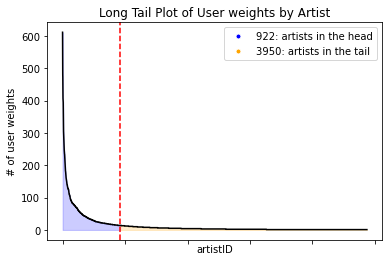

bottom 10 artists: 
9375     Justin Hinds & The Dominoes
9376                  The Techniques
9377                  Phyllis Dillon
9378                   Clancy Eccles
9381               Dandy Livingstone
9383                      Slim Smith
9388                     The Maytals
9391                       Pat Kelly
9393                   The Melodians
17625                     Apollo 440
Name: name, dtype: object


total removed artists: 3673


line divides top 80.0 % cumulative sum of users:


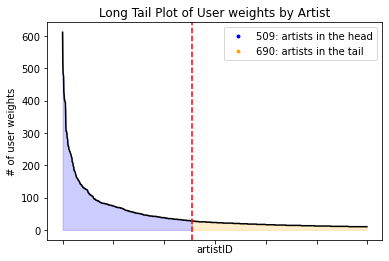

bottom 10 artists - filtered dataset: 
150                        VAST
451                Aaron Carter
1339                   Alestorm
1376            Thirteen Senses
3291                 HorrorPops
3338               Ryan Cabrera
3345    Os Paralamas do Sucesso
3394            Alien Sex Fiend
3507                       Aqua
4956             Paul Oakenfold
Name: name, dtype: object


filtered dataset shape: (55863, 3)
unique artists after removal:  1199
% of removed records: 0.1515


**Remove User with lowcount of samples (artists)**
df original shape:  (55863, 3)
unique users:  1874
users with less than 10 artists: 107
unique users after removal:  1767
df new shape:  (55284, 3)
% of removed records: 0.0104


In [189]:
#remove artist with less than 10 users
df = remove_rare_artists (df,artist_df,min_users = 10)

#remove users who have listened to less than 10 artists
df = remove_users_lowcount (df,min_artists = 10)




In [190]:
#scaling
#df = scale_weight_by_user(df)

### train/test

In [191]:
#5 samples per user
train, test = train_test_split(df,sample_size=5,seed=2021)



**Train-Test Split**
input data shape: (55284, 3)
train set shape: (46449, 3)
test set shape: (8835, 3)


OK: all artists from the test set are part on the train set as well


### Train Data Matrix

In [192]:
#Sparse matrix, we need to pivot the data
data_pivot = train.pivot(index='userID',
                                       columns='artistID').fillna(0).astype(int)
data_pivot.head()

#Trying to make it more memory efficient
# create scipy sparse from pivot tables
#data_sparse = sparse.csr_matrix(data_pivot)
#data_sparse.shape

weight                                                           ...  \
artistID  7     9     15    25    36    40    45     51     52     53     ...   
userID                                                                    ...   
2             0     0     0     0     0     0     0  13883  11690  11351  ...   
4             0     0     0     0     0     0     0      0      0    686  ...   
5             0     0     0     0     0     0     0      0      0    181  ...   
6             0     0     0     0     0     0     0      0      0      0  ...   
7             0     0     0     0     0     0     0      0      0      0  ...   

                                                                      
artistID 7260  7324  7340  7639  7663  7665  7868  8155  8594  10969  
userID                                                                
2            0     0     0     0     0     0     0     0     0     0  
4            0     0     0     0     0     0     0     0     0     0  
5            0     0     0     0     0     0     0     0     0     0  
6            0     0     0     0     0     0     0     0     0     0  
7            0     0     0     0     0     0     0     0     0     0  

[5 rows x 1199 columns]

## Colaborative Filtering

In [195]:
#fit model = generate cosine matrix for the train set
cosine_matrix = similarity(data_pivot,kind='user')


In [196]:
cosine_matrix

userID,2,4,5,6,7,8,9,10,11,12,...,2086,2087,2088,2090,2091,2092,2093,2094,2096,2097
userID,,,,,,,,,,,,,,,,,,,,,
2,1.000,0.143,0.039,0.000,0.033,0.023,0.000,0.000,0.021,0.003,...,0.000,0.021,0.011,0.000,0.067,0.000,0.006,0.002,0.001,0.086
4,0.143,1.000,0.089,0.000,0.000,0.000,0.000,0.012,0.016,0.027,...,0.045,0.001,0.050,0.000,0.000,0.004,0.008,0.000,0.049,0.761
5,0.039,0.089,1.000,0.000,0.000,0.000,0.000,0.147,0.006,0.000,...,0.171,0.003,0.018,0.033,0.000,0.098,0.000,0.000,0.117,0.104
6,0.000,0.000,0.000,1.000,0.000,0.035,0.000,0.000,0.000,0.000,...,0.000,0.010,0.042,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.033,0.000,0.000,0.000,1.000,0.245,0.000,0.000,0.168,0.042,...,0.000,0.264,0.286,0.000,0.000,0.000,0.000,0.019,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,0.000,0.004,0.098,0.000,0.000,0.000,0.000,0.095,0.003,0.000,...,0.019,0.000,0.238,0.016,0.000,1.000,0.000,0.000,0.059,0.036
2093,0.006,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.098,0.043,0.000,0.000,1.000,0.000,0.007,0.000
2094,0.002,0.000,0.000,0.000,0.019,0.076,0.000,0.000,0.062,0.012,...,0.000,0.028,0.016,0.000,0.000,0.000,0.000,1.000,0.000,0.000


In [197]:
#Subjective Testing using the matrix
user = np.random.choice(cosine_matrix.index)#pick a row from train matrix
n_neighbors = 5

table = cosine_matrix.reset_index()
user_row = table[table['userID']==user] #pick user row
user_row = user_row.iloc[: , 1:].transpose() #drop first column and transpose
user_row.columns=['distance']
user_row = user_row.sort_values(by='distance',ascending=False) #higher is closer

neighbors = list(user_row.head(n_neighbors+1).index)
distances = list(user_row['distance'].head(n_neighbors+1))

top_artists = get_top_artists(user,5)
print(f"Neighbors for user {user}\ntop 5: {top_artists}\n")

for i in range(1,n_neighbors+1):
        top_artists = get_top_artists(neighbors[i],5)
        print(f"{i}: User {neighbors[i]} \n distance {distances[i]}\n top artists: {top_artists}\n")


Neighbors for user 495
top 5: ['Pink', 'Katy Perry', 'Janet Jackson', 'Céline Dion', 'Emily Osment']

1: User 703 
 distance 0.7630725709354979
 top artists: ['Ana Carolina', 'The Pussycat Dolls', 'Rick Aziago', 'Madonna', 'Britney Spears씨']

2: User 501 
 distance 0.7529820189328026
 top artists: ['Pink', 'Gwen Stefani', 'Jordin Sparks', 'Fresno', 'Evanescence']

3: User 256 
 distance 0.7517292743733036
 top artists: ['Edward Maya', 'Marisa Monte', 'Lorena Simpson', 'Ivete Sangalo', 'Cheryl Cole']

4: User 717 
 distance 0.7484664173625006
 top artists: ['Ashlee Simpson', 'Kelly Clarkson', 'Girls Aloud', 'Hilary Duff', 'Fergie']

5: User 1564 
 distance 0.7456711770441324
 top artists: ['Panic! At the Disco', 'Enrique Iglesias', 'Dulce María', 'Wanessa', 'Jonas Brothers']



In [198]:
#DO NOT USE
recommend_knn(user,10,10)

computed scores:  1198
scores higher than 0:  124
scores for unknown artists:  113


<ipython-input-194-91e1ec39bf7a>:91: RuntimeWarning: invalid value encountered in true_divide
  scores = scores/n_valid


,artistID,weight,name
16,290,19456.054,Jordin Sparks
9,205,2663.123,Andrew Bird
19,293,1768.156,Ashlee Simpson
61,499,1482.527,Flyleaf
2,91,1427.625,Nik Kershaw
88,975,1261.254,Santana
25,301,1078.591,Alicia Keys
81,905,1014.228,Crowded House
97,1257,761.098,Overkill
22,296,755.467,Sugababes


In [199]:
#if a neighbor is a heavy user, this normalizes the listening habits so that the neighbor artists 
#doesnt weight as much. USE THIS
recommend_knn_normalized(user,10,10)

computed scores:  1198
scores for unknown artists:  1174


<ipython-input-194-91e1ec39bf7a>:167: RuntimeWarning: divide by zero encountered in true_divide
  scores = scores/n_valid


,artistID,weight,name
131,290,18638.063,Jordin Sparks
134,293,950.165,Ashlee Simpson
142,301,141.078,Alicia Keys
137,296,-331.449,Sugababes
35,91,-466.065,Nik Kershaw
174,355,-570.246,Jason Mraz
11,56,-587.985,Daft Punk
21,68,-812.020,Icehouse
144,304,-871.749,David Archuleta
224,462,-911.015,Blue


In [200]:
def predict_knn_normalized (user,similarity,k):
    #get top n neighbors and distances
    table = similarity.reset_index()
    user_row = table[table['userID']==user] #pick user row
    user_row = user_row.iloc[: , 1:].transpose() #drop first column and transpose
    user_row.columns=['distance']
    user_row = user_row.sort_values(by='distance',ascending=False) #higher is closer
    neighbors = list(user_row.head(k+1).index)
    neighbors = neighbors[1:]
    distances = list(user_row['distance'].head(k+1))
    distances = np.array(distances[1:]).reshape(-1,1)

    #user bias
    user_scores = data_pivot[data_pivot.index==user].values #user scores
    user_bias = float(user_scores.sum(1)/(user_scores != 0).sum(1))

    #compute scores for artists
    ratings = data_pivot[data_pivot.index.isin(neighbors)].values #neighboors scores
    neighbor_bias = ratings.sum(1)/(ratings != 0).sum(1) #mean at user level
    ratings = (ratings - neighbor_bias[:, np.newaxis]).copy() #subtract mean from weights
    pred = distances.T.dot(ratings) / len(distances)  #dot product normalized
    pred += user_bias

    return pred


#def knn_rmse (test_set,similarity,k):
    
    

In [301]:
pred = predict_knn_normalized(2,cosine_matrix,30)

In [ ]:
#Score Test Set

In [318]:
artist_ids = np.array(data_pivot.columns.get_level_values(1))
artist_ids

array([    7,     9,    15, ...,  8155,  8594, 10969])

In [323]:
int(np.where(artist_ids==7)[0])

0

In [350]:
k_values = [5,10,20,30,50,100]
rmse = []
artist_ids = np.array(data_pivot.columns.get_level_values(1))
for k in k_values:
    users = list(test['userID'].unique())
    scores = []

    for u in users:
        artists = list(test[test['userID']==u]['artistID'].unique())
        pred = predict_knn_normalized(u,cosine_matrix,k)
        for a in artists:
            scores.append(float(pred[:,int(np.where(artist_ids==a)[0])]))
    df = test
    df['pred'] = scores
    df['sqerr'] = (df['weight']-df['pred'])**2
    rmse.append(df['sqerr'].sum()**0.5)
    
plt.plot(k_values,rmse)
plt.show()    

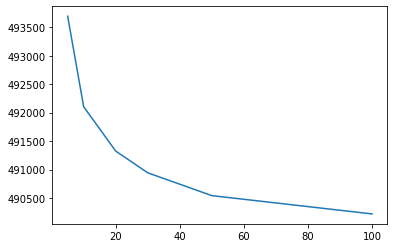

In [351]:
plt.plot(k_values,rmse)
plt.show()

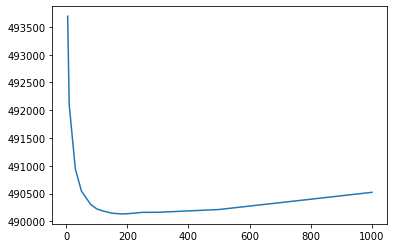

In [358]:
#Testing RMSE on the TEST SET for different K values
k_values = [5,10,30,50,80,100,120,150,180,200,250,300,500,1000]
rmse = []
artist_ids = np.array(data_pivot.columns.get_level_values(1))
for k in k_values:
    users = list(test['userID'].unique())
    scores = []

    for u in users:
        artists = list(test[test['userID']==u]['artistID'].unique())
        pred = predict_knn_normalized(u,cosine_matrix,k)
        for a in artists:
            scores.append(float(pred[:,int(np.where(artist_ids==a)[0])]))
    df = test
    df['pred'] = scores
    df['sqerr'] = (df['weight']-df['pred'])**2
    rmse.append(df['sqerr'].sum()**0.5)
    
plt.plot(k_values,rmse)
plt.show() 


In [359]:
rmse

[493691.7531095044,
 492102.86492475297,
 490944.36954278563,
 490543.9036738474,
 490304.2672756346,
 490223.00631192815,
 490186.29009951587,
 490145.35953069007,
 490132.50816666073,
 490135.84584159375,
 490160.6246060244,
 490161.8297446965,
 490211.86346452025,
 490521.33819330187]

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

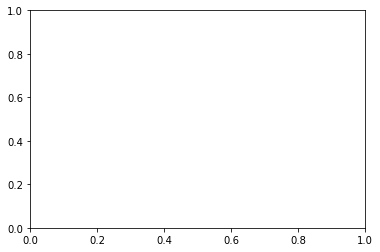

In [354]:
plt.plot(k_values,rmse)
plt.show() 
plt.xlable('k_value')
plt.title('c')

## create user clusters from KNN output

In [216]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=8,
              affinity = 'precomputed', 
              random_state=2021).fit(cosine_matrix.values)
labels = list(clustering.labels_)
user_ids = list(cosine_matrix.index)
df = pd.DataFrame(list(zip(user_ids,labels))
                 ,columns = ['userID','cluster'])
df

,userID,cluster
0,2,1
1,4,7
2,5,0
3,6,1
4,7,1
...,...,...
1762,2092,0
1763,2093,3
1764,2094,1
1765,2096,0


In [217]:
df['cluster'].value_counts()

1    660
0    432
3    215
4    146
7    132
6     85
5     80
2     17
Name: cluster, dtype: int64

In [219]:
#Test if the output makes sense:
#Yes they kinda look like genres, we could make a genre cloud
cluster = 2
users = list(df[df['cluster']==cluster]['userID'])
for i in range(10):
    print(f"user {users[i]}, top artists: {get_top_artists(users[i],3)}") 
    
    
    

user 78, top artists: ['edIT', 'Gojira', 'Limewax']
user 416, top artists: ["raison d'être", 'Kammarheit', 'Eluvium']
user 440, top artists: ['Built to Spill', 'Grizzly Bear', 'Panda Bear']
user 586, top artists: ['Sorrow', 'Pastetai', 'Anubi']
user 697, top artists: ['Justin Timberlake', 'dZihan & Kamien', 'Air']
user 842, top artists: ['Dibiase', 'Dizzee Rascal', 'Zomby']
user 928, top artists: ['Wagon Christ', 'Orbital', 'Air']
user 936, top artists: ['Dimlite', 'The Ghost Orchid', 'The Tuss']
user 1155, top artists: ['Hudson Mohawke', 'Dave House', 'Modest Mouse']
user 1284, top artists: ['Stephen Rippy', 'o9', 'I Am Robot and Proud']
